In [1]:
# Data Preparation

In [24]:
import numpy as np
import pandas as pd
import hvplot.pandas

%matplotlib inline

In [3]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [4]:
# Load the Valero daily data
df = pd.read_csv('16-Project-2/data/cleandata/VLO_Daily.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns=["Open", "High", "Low", "Adj Close", "Volume"])
df.head()

,Close
Date,
2017-01-03,70.419998
2017-01-04,67.889999
2017-01-05,67.680000
2017-01-06,66.660004
2017-01-09,66.370003


In [5]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [6]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Try a window size anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 1 is the `Close` column
feature_column = 0
target_column = 0
X, y = window_data(df, window_size, feature_column, target_column)

In [7]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

In [8]:
# Use MinMaxScaler to scale the data between 0 and 1. 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [9]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:10]} \n")
print (f"X_test sample values:\n{X_test[:10]}")


X_train sample values:
[[[0.14213112]
  [0.10195328]
  [0.09861837]
  [0.08242025]
  [0.07781486]
  [0.08035569]
  [0.08909006]
  [0.08019685]
  [0.07813241]
  [0.07495634]]

 [[0.10195328]
  [0.09861837]
  [0.08242025]
  [0.07781486]
  [0.08035569]
  [0.08909006]
  [0.08019685]
  [0.07813241]
  [0.07495634]
  [0.08384943]]

 [[0.09861837]
  [0.08242025]
  [0.07781486]
  [0.08035569]
  [0.08909006]
  [0.08019685]
  [0.07813241]
  [0.07495634]
  [0.08384943]
  [0.07305064]]

 [[0.08242025]
  [0.07781486]
  [0.08035569]
  [0.08909006]
  [0.08019685]
  [0.07813241]
  [0.07495634]
  [0.08384943]
  [0.07305064]
  [0.07575031]]

 [[0.07781486]
  [0.08035569]
  [0.08909006]
  [0.08019685]
  [0.07813241]
  [0.07495634]
  [0.08384943]
  [0.07305064]
  [0.07575031]
  [0.07590915]]

 [[0.08035569]
  [0.08909006]
  [0.08019685]
  [0.07813241]
  [0.07495634]
  [0.08384943]
  [0.07305064]
  [0.07575031]
  [0.07590915]
  [0.10147689]]

 [[0.08909006]
  [0.08019685]
  [0.07813241]
  [0.07495634]
  [0.

In [10]:
# Build and Tranin the LSTM RNN

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [12]:
# The LSTM RNN model.
model = Sequential()

number_units = 10
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [13]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 10)            480       
_________________________________________________________________
dropout (Dropout)            (None, 10, 10)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 10)            840       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                840       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [15]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Train on 429 samples
Epoch 1/10
429/429 [==============================] - 8s 18ms/sample - loss: 0.0101TA: 9s
Epoch 2/10
429/429 [==============================] - 4s 10ms/sample - loss: 0.0182
Epoch 3/10
429/429 [==============================] - 4s 10ms/sample - loss: 0.01791s - loss: 0.018
Epoch 4/10
429/429 [==============================] - 4s 10ms/sample - loss: 0.0178- ETA: 2s - loss: 0.020 - ETA: 2s - ETA: 1s - los - ETA: 0s - loss: 0.01 - ETA: 0s - lo
Epoch 5/10
429/429 [==============================] - 4s 10ms/sample - loss: 0.01253s - loss: 0 - ETA: 3s - loss: 0.0 - ETA: 3s - loss: 0.019 - ETA: 2s - loss: 0 - ETA: 2 - ETA: 1s - loss: 0. - ETA: 1s - los - ETA: 0s -
Epoch 6/10
429/429 [==============================] - 5s 11ms/sample - loss: 0.00953s - loss - ETA - ETA: 
Epoch 7/10
429/429 [==============================] - 5s 11ms/sample - loss: 0.0080
Epoch 8/10
429/429 [==============================] - 5s 11ms/sample - loss: 0.00823s - loss - - ETA: 1s - - ETA: 0s 
Epoch

In [16]:
# Model Performance

In [17]:
# Evaluate the model
model.evaluate(X_test, y_test)

185/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.052108617006121453

In [18]:
# Predictions
predicted = model.predict(X_test)

In [20]:
# # Recovering the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [21]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
})
stocks.head()

,Real,Predicted
0,115.519997,116.102966
1,119.989998,116.078949
2,117.220001,116.152145
3,117.110001,116.219948
4,116.180000,116.265579


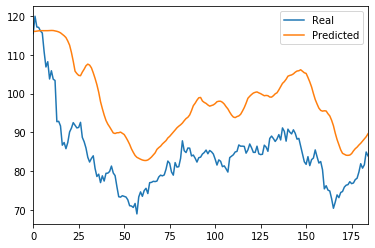

In [25]:
# Plot the real vs predicted prices as a line chart
stocks.plot()